In [333]:
from sea_breeze.load_model_data import *
from sea_breeze.sea_breeze_funcs import *
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from climtas.nci import GadiClient
import hvplot.xarray
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37925,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: 7 hours ago,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:38073,Total threads: 1
Dashboard: /proxy/44539/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36383,


In [276]:
lat_slice=slice(-45,-8)
lon_slice=slice(110,155)
# lat_slice=slice(-45,-30)
# lon_slice=slice(140,155)
t1="2024-01-29 00:00"
t2="2024-01-29 06:00"

In [277]:
#Load BARRA surface variables for frontogenesis function (surface temp, moisture, wind)
domain_id = "AUS-11"
freq = "1hr"
vert_coord = "pressure"
barra_var_names = ["uas","vas","ts","huss"]
barrar_vars = load_barra_variable(barra_var_names, t1, t2, domain_id, freq, lat_slice, lon_slice, chunks={"lat":-1,"lon":-1})
barrar_angles = load_angle_ds("/g/data/gb02/ab4502/coastline_data/barra_r_angles_v2.nc",lat_slice,lon_slice)
orog, lsm = load_barra_static(domain_id,lon_slice,lat_slice)

In [278]:
unames = ["ua700"]
vnames = ["va700"]
barrar_wind_ds = load_barra_wind_data(unames, vnames, t1, t2, domain_id, freq, lat_slice, lon_slice, vert_coord)

In [279]:
uprime_pl, vprime_pl = rotate_u_v_coast(barrar_wind_ds["u"], barrar_wind_ds["v"], barrar_angles.angle_interp)
uprime_sfc, vprime_sfc = rotate_u_v_coast(barrar_vars["uas"]["uas"], barrar_vars["vas"]["vas"], barrar_angles.angle_interp)

In [280]:
land_sea_diff = land_sea_temperature_diff(barrar_vars["ts"]["ts"],lsm,10)
land_sea_diff = land_sea_diff.where(land_sea_diff>0, 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 27.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


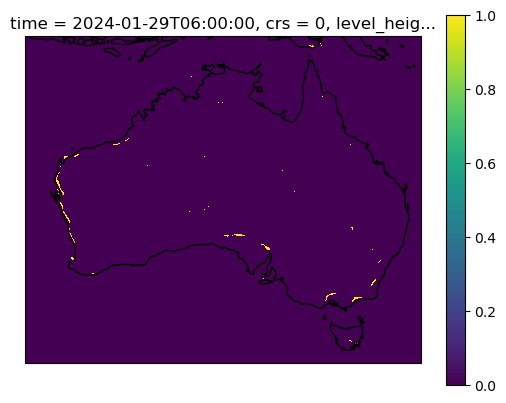

In [331]:
ax=plt.axes(projection=ccrs.PlateCarree())
((vprime_sfc.diff(dim="time")>2) & (((barrar_vars["huss"]["huss"]).diff(dim="time")>0.0005)) & (land_sea_diff >= 1.5)).isel(time=-1).plot()
ax.coastlines()

In [297]:
land_sea_grad = land_sea_temperature_grad(barrar_vars["ts"]["ts"],lsm,10,barrar_angles)


100%|██████████| 337/337 [01:07<00:00,  5.01it/s]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 26.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


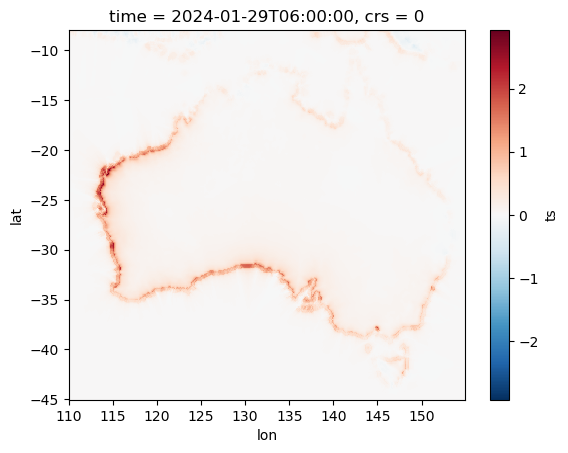

In [310]:
land_sea_grad.isel(time=-1).plot()

In [334]:
land_sea_diff.isel(time=-1).hvplot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 25.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 25.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


:Image   [lon,lat]   (ts)

In [335]:
barrar_vars["ts"]["ts"].isel(time=-1).hvplot()

:Image   [lon,lat]   (Surface Temperature)

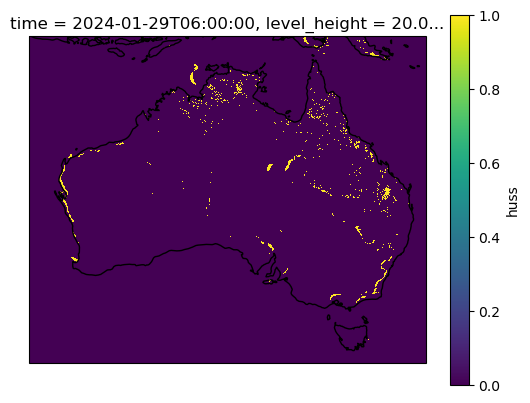

In [293]:
ax=plt.axes(projection=ccrs.PlateCarree())
((barrar_vars["huss"]["huss"]).diff(dim="time")>0.001).isel(time=-1).plot()
ax.coastlines()

In [146]:
#This code replaces the time coordinte of the wind dataset with LST. But has to interpolate linearly through time 

lon = lsm.lon
times_lst = [pd.to_datetime(barrar_wind_ds.time.values) + dt.timedelta(hours=l / 180 * 12) for l in lon.values]
times_lst_out = pd.date_range(pd.to_datetime(times_lst[0].min()).round("h"), 
                              pd.to_datetime(times_lst[-1].max()).round("h"), freq="1h")

temp = xr.concat([xr.Dataset(barrar_wind_ds.sel(lon=lon.values[l])).\
        assign_coords({"time":times_lst[l]}).\
        interp(time=times_lst_out,method="linear") for l in np.arange(lon.shape[0])], "lon")

In [239]:
#This code creates an array of local solar times (lat/lon/UTCtime), that can be used to constuct conditions (e.g. where is it 2-4 in LST and winds
# are onshore)

lst_array = xr.DataArray(
    np.repeat(np.stack([pd.to_datetime(barrar_wind_ds.time.values) + dt.timedelta(hours=l / 180 * 12) for l in lon.values])[np.newaxis,:,:],
          lsm.lat.shape[0],axis=0),
    coords={"lat":lsm.lat,"lon":lsm.lon,"time":barrar_wind_ds.time})